<a href="https://colab.research.google.com/github/kharisecario/practice/blob/gh-pages/ECG_to_HRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -V
!pip install neurokit2
!pip install pyhrv
!pip install vectorizedsampleentropy
!pip install heartpy
!pip install scipy==1.8.0

Python 3.10.12


In [ ]:
import pickle
import sys
import numpy as np
import os
import scipy.signal as sg
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
import glob
import pandas as pd
import neurokit2 as nk
import csv
from collections import Counter
import warnings
from IPython.display import display
import shutil
import posixpath
import pyhrv
import json
from vectorizedsampleentropy import vectsampen as vse
import math
import heartpy as hp
# from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
import pyhrv.tools as tools
import glob
from sklearn.metrics import r2_score
import collections
from math import sqrt
from sklearn.metrics import mean_squared_error
import scipy.signal
from biosppy.signals import ecg
import gc
import bz2
gc.enable()
pd.set_option('display.max_colwidth', None)
fs = 125
base_dir = "dataset"
sampling_rate = 360
invalid_labels = ['|', '~', '!', '+', '[', ']', '"', 'x']  # non-beat labels
before = 90
after = 110
tol = 0.05
cpuCount = os.cpu_count()
import psutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# setting  HRV functuon
def estimate_shannon_entropy(dna_sequence):
            m = len(dna_sequence)
            bases = collections.Counter([tmp_base for tmp_base in dna_sequence])

            shannon_entropy_value = 0
            for base in bases:
        # number of residues
                n_i = bases[base]
        # n_i (# residues type i) / M (# residues in column)
                p_i = n_i / float(m)
                entropy_i = p_i * (math.log(p_i, 2))
                shannon_entropy_value += entropy_i

            return shannon_entropy_value * -1


def poincare_sd2(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)


    return sd2


def hrvtransform_filter_rr(rr_normal,fs,hrv1,settings_time,settings_welch,settings_ar,settings_lomb,settings_nonlinear):



#         working_data, measures = hp.process(hrdata1, fs)
#hp.plotter(working_data, measures)


        nni = np.array(rr_normal)
        nni_old = nni
        # nni filter in hr 50~150
        hr = 60/(nni/1000)
        ind0=np.where((hr >= 50 ) &  (hr <= 150))
#         normal_hr_filter_in50_150=np.array(hr)[ind0]

        #update nni  with  50<= HR  <= 150
        nni = np.array(nni)[ind0]
#         total_time_proportion=sum(nni)/sum(rri_0)
#         number_proportion=len(nni)/len(rri_0)

        hr = 60/(nni/1000)
#  Mean.rate
        meanrate= np.mean(hr)

# Poincar..SD2
        sd2=poincare_sd2(nni)


   # Compute the pyHRV parameters
        results = pyhrv.hrv(nni=nni,
                       kwargs_time=settings_time,
                       kwargs_welch=settings_welch,
                       kwargs_ar=settings_ar,
                       kwargs_lomb=settings_lomb,
                       kwargs_nonlinear=settings_nonlinear)





#DFA.Alpha.1
        DFA_Alpha1 = results['dfa_alpha1']





#LF.HF.ratio.LombScargle
        ratio=results['lomb_ratio']

        nni0=np.array(nni)/1000

        nni_diff=np.diff(nni0)
        nni_rmfirst=nni0[1:]

# aFdP
# RR allan factor  distance

        aFdP = np.var(nni_diff)/(2*np.mean(nni_rmfirst) ) -1



# fFdP
# RR fano factor distance
        fano_rr = np.var(nni0)/np.mean(nni0)
        fFdP =fano_rr-1

        ax = pd.plotting.autocorrelation_plot(nni0)
        c0=ax.lines[5].get_data()[1]
        arr = np.array(c0)

        df = pd.DataFrame(data=nni0)
        df.columns =['rr']
        df['time'] =np.cumsum(df['rr'])
        columns_titles = ["time","rr"]
        df=df.reindex(columns=columns_titles)
        df['stationary']=df['rr'].diff(arr.argmax(0))




# the autoregression model
        X = df['stationary'].dropna()
        model = AutoReg(X,lags=1)
        model_fitted = model.fit()
        predictions = model_fitted.predict()
        predictions =predictions.dropna()
        r2 = r2_score(X.tail(len(predictions)), predictions)
        rmse = sqrt(mean_squared_error(X.tail(len(predictions)), predictions))

        df['stationary']=df['rr'].diff(1)
#create datasets
        X = df['stationary'].dropna()

#train the autoregression model
#         model = AR(X)
        model = AutoReg(X,lags=1)
        model_fitted = model.fit()
        predictions = model_fitted.predict()
        predictions =predictions.dropna()
        r2 = r2_score( X.tail(len(predictions)), predictions)
        rmse = sqrt(mean_squared_error( X.tail(len(predictions)), predictions))
# Aerr
        ARerr = rmse


        L = nni
        r = 0.2*np.std(L)
        m = 1
        QSE=vse.qse(L, m, r)

        shannEn=estimate_shannon_entropy(nni0)




#======================================================================================================================

        ratio=float(ratio)
        DFA_Alpha1=float(DFA_Alpha1)
        sd2=sd2/1000



        hrvvar = np.asarray([aFdP,fFdP,ARerr,DFA_Alpha1,meanrate,sd2,shannEn,ratio])


        hrv0 = pd.DataFrame(hrvvar)
#hrv0
        hrv0=hrv0.transpose()

        hrv1=hrv1.append(hrv0)
        hrv1.columns=['aFdP', 'fFdP', 'ARerr', 'DFA.Alpha.1', 'Mean.rate','Poincar..SD2', 'shannEn', 'LF.HF.ratio.LombScargle']


        plt.close('all')

        df1 = pd.DataFrame(hrv1)
        a0 = df1.reset_index(drop=True)
        a0 = pd.DataFrame(a0)
        finalhrv = a0.drop([0])
        for i in finalhrv.columns:
                 finalhrv[i] = pd.to_numeric(finalhrv[i])
        return finalhrv

In [ ]:
# load data
read_file = pd.read_csv('https://raw.githubusercontent.com/CGproject-record/From_ECG_to_HRV/main/cgmh_data_ECG_10min.csv')
read_file

,index,II,NONEABP,PLETH,RESP,RESP,HR,PULSE,SpO2,NBP SYS,...,ABP SYS,ABP DIAS,Tblood,CVP,CCI,CCO,C.I.,CO,SVRI,sumpt
0,2022-07-09 03:54:00.008,76.0,25.0,157.0,100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-09 03:54:00.016,77.0,24.0,154.0,100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-07-09 03:54:00.024,77.0,22.0,150.0,99.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-07-09 03:54:00.032,78.0,21.0,146.0,99.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-09 03:54:00.040,78.0,20.0,142.0,98.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,2022-07-09 04:03:59.968,80.0,45.0,136.0,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74996,2022-07-09 04:03:59.976,81.0,44.0,133.0,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74997,2022-07-09 04:03:59.984,82.0,43.0,129.0,155.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74998,2022-07-09 04:03:59.992,83.0,42.0,127.0,155.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ECG_data = read_file['II']
ECG_data

0        76.0
1        77.0
2        77.0
3        78.0
4        78.0
         ... 
74995    80.0
74996    81.0
74997    82.0
74998    83.0
74999    85.0
Name: II, Length: 75000, dtype: float64

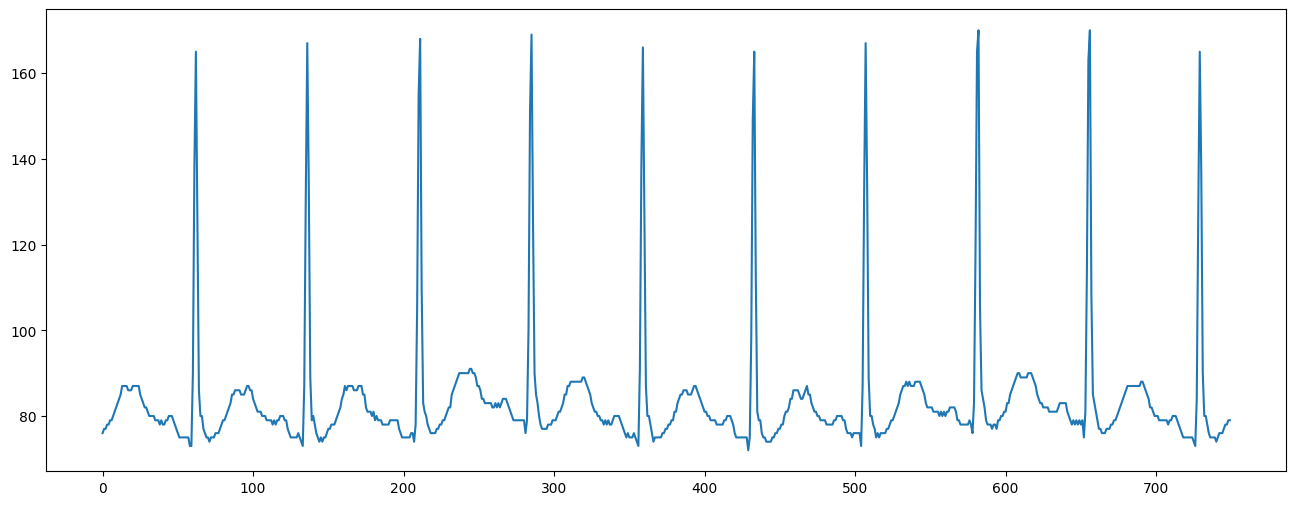

In [ ]:
ex_signal = ECG_data[0:750]

#and visualise
plt.figure(figsize=(16,6))
plt.plot(ex_signal)
plt.show()

In [ ]:
# #and visualise if need
# plt.figure(figsize=(16,6))
# plt.plot(ex_signal[0:1500])
# plt.show()

In [ ]:
# find RR

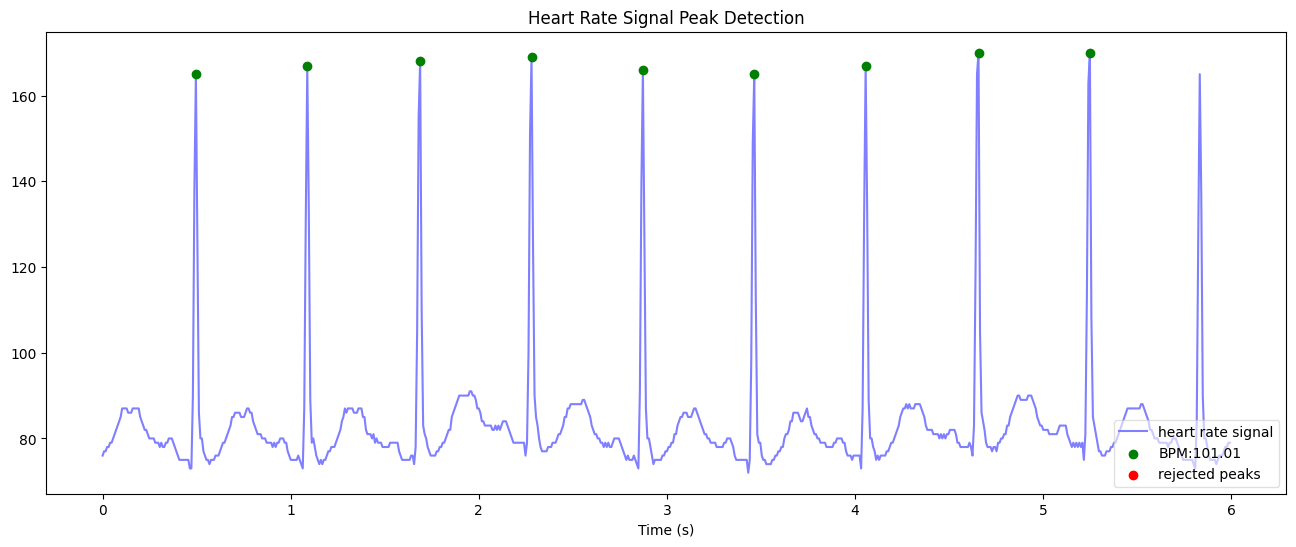

In [ ]:
#run the analysis
# hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
wd, m = hp.process(np.array(ex_signal), sample_rate = fs)

#call plotter
hp.plotter(wd, m,figsize = (16,6))

In [ ]:
RR_rm_nan = wd['RR_list']
RR_rm_nan

array([592., 600., 592., 592., 592., 592., 600., 592., 584., 592., 592.,
       600., 584., 592., 584., 600., 584., 592., 584., 592., 592., 584.,
       584., 584., 592., 592., 584., 592., 584., 592., 592., 592., 584.,
       600., 592., 592., 584., 600., 592., 592., 592., 592., 600., 592.,
       592., 592., 584., 592., 600., 584., 584., 592., 592., 584., 584.,
       592., 592., 592., 584., 592., 584., 600., 592., 592., 584., 592.,
       592., 592., 592., 592., 592., 592., 592., 592., 584., 600., 584.,
       592., 584., 592., 600., 584., 592., 592., 592., 592., 592., 584.,
       592., 592., 592., 584., 592., 592., 592., 584., 592., 592., 584.,
       592.])

In [ ]:
import matplotlib.pyplot as plt

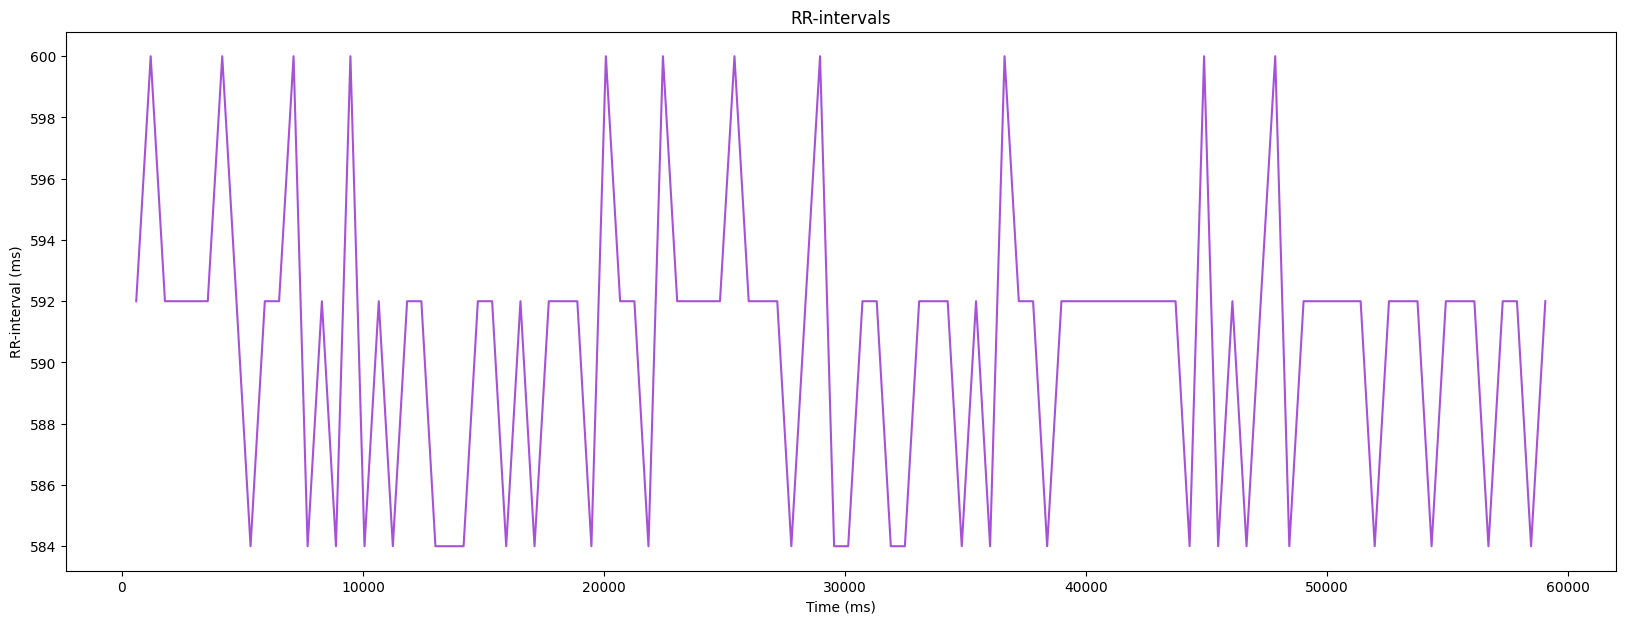

In [ ]:
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(RR_rm_nan), RR_rm_nan, label="RR-interval", color="#A651D8")
plt.show()

In [ ]:
hrv1=pd.DataFrame(['NA','NA','NA','NA','NA','NA','NA','NA'])
h0=hrv1.transpose()
h0.columns =['aFdP', 'fFdP', 'ARerr', 'DFA.Alpha.1', 'Mean.rate',
                       'Poincar..SD2', 'shannEn', 'LF.HF.ratio.LombScargle']
hrv1=hrv1.transpose()
# Define HRV input parameters
# Time Domain Settings
settings_time = {
    'threshold': 50,            # Computation of NNXX/pNNXX with 50 ms threshold -> NN50 & pNN50
    'plot': True,               # If True, plots NNI histogram
    'binsize': 7.8125           # Binsize of the NNI histogram
}

# Frequency Domain Settings
settings_welch = {
    'nfft': 2 ** 12,            # Number of points computed for the FFT result
    'detrend': True,            # If True, detrend NNI series by subtracting the mean NNI
    'window': 'hanning'         # Window function used for PSD estimation
}

settings_lomb = {
    'nfft': 2**8,               # Number of points computed for the Lomb PSD
    'ma_size': 5                # Moving average window size
}

settings_ar = {
    'nfft': 2**12,              # Number of points computed for the AR PSD
    'order': 32                 # AR order
}

# Nonlinear Parameter Settings
settings_nonlinear = {
    'short': [4, 16],           # Interval limits of the short term fluctuations
    'long': [17, 64],           # Interval limits of the long term fluctuations
    'dim': 2,                   # Sample entropy embedding dimension
    'tolerance': None           # Tolerance distance for which the vectors to be considered equal (None sets default values)
}
fs = 125

In [ ]:
hrv_part1 = hrvtransform_filter_rr(RR_rm_nan,fs,hrv1,settings_time,settings_welch,settings_ar,settings_lomb,settings_nonlinear)
hrv_part1

/usr/local/lib/python3.10/dist-packages/pyhrv/utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
/usr/local/lib/python3.10/dist-packages/pyhrv/time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")
/usr/local/lib/python3.10/dist-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and wi

,aFdP,fFdP,ARerr,DFA.Alpha.1,Mean.rate,Poincar..SD2,shannEn,LF.HF.ratio.LombScargle
1,-0.999951,-0.999961,0.005992,0.361367,101.591448,0.00419,1.29951,0.284471


In [ ]:
#generate HRV from hrvanalysis note  install hrvanalysis 會有錯

In [ ]:
!pip install hrv-analysis

In [ ]:
from hrvanalysis import get_time_domain_features,get_geometrical_features,get_frequency_domain_features,get_csi_cvi_features,get_poincare_plot_features,get_sampen
nn_intervals_list = RR_rm_nan

In [ ]:
time_domain_features = get_time_domain_features(nn_intervals_list)
time_domain_features

{'mean_nni': 590.64,
 'sdnn': 4.831546169068281,
 'sdsd': 7.627700713964739,
 'nni_50': 0,
 'pnni_50': 0.0,
 'nni_20': 0,
 'pnni_20': 0.0,
 'rmssd': 7.627700713964739,
 'median_nni': 592.0,
 'range_nni': 16.0,
 'cvsd': 0.012914297565293139,
 'cvnni': 0.008180187879365232,
 'mean_hr': 101.59144761199555,
 'max_hr': 102.73972602739725,
 'min_hr': 100.0,
 'std_hr': 0.8264102645517728}

In [ ]:
get_geometrical_features(nn_intervals_list)

{'triangular_index': 1.639344262295082, 'tinn': None}

In [ ]:
get_frequency_domain_features(nn_intervals_list)

{'lf': 2.5088555715803063,
 'hf': 5.243859360060307,
 'lf_hf_ratio': 0.47843685333915076,
 'lfnu': 32.360993454577944,
 'hfnu': 67.63900654542205,
 'total_power': 8.024570396821508,
 'vlf': 0.27185546518089465}

In [ ]:
get_csi_cvi_features(nn_intervals_list)

{'csi': 0.7672534718143821,
 'cvi': 2.5572252570092084,
 'Modified_csi': 12.765003021377476}

In [ ]:
get_poincare_plot_features(nn_intervals_list)

{'sd1': 5.421047417431508,
 'sd2': 4.159317451894714,
 'ratio_sd2_sd1': 0.7672534718143821}

In [ ]:
get_sampen(nn_intervals_list)

{'sampen': 0.8327040157658894}